In [1]:
import os
import sys
from collections import defaultdict
from functools import reduce, partial

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from pymutspec.annotation import CodonAnnotation
from pymutspec.constants import possible_codons

# Swap that to True if you want to invert nucls
INVERT = True
#Change to true to filter mutspecs by num of total muts and num of mut types
FILTER = True

In [2]:
def chop(l, chunk_size):
    for i in range(0, len(l), chunk_size):
        yield l[i:i + chunk_size]

def filter(mutspec12, meta_df, at_least_n_muts=15, at_least_n_mut_types=4, ms_type=12, filter_mut_types=True):
    #removing species with less than 15 total mutations - might need to bump up for all insects (do not do it for termites)
    mut_ammount_df = mutspec12.groupby(mutspec12['Species']).aggregate({'ObsNum' : 'sum'}).reset_index()
    less_than_15_total_muts = mut_ammount_df.drop(mut_ammount_df[mut_ammount_df['ObsNum'] > at_least_n_muts].index)['Species'].to_list()
    for sp in less_than_15_total_muts:
        mutspec12 = mutspec12.drop(mutspec12[mutspec12['Species'] == sp].index)
        meta_df = meta_df.drop(meta_df[meta_df['Species'] == sp].index)

    if filter_mut_types == False:
        return mutspec12, meta_df
    
    #removing species with less than 4 mutation types - might need to bump up for all insects (do not do it for termites)
    species = mutspec12['Species'].drop_duplicates().to_list()
    obsnum_values = mutspec12['ObsNum'].to_list()
    chopped_obsnum =  list(chop(obsnum_values, ms_type))
    
    species_and_obsnum = {}
    for i in range(len(species)):
        species_and_obsnum[species[i]] = chopped_obsnum[i]
    
    less_than_4_mut_types = []
    for sp, obsnum_list in species_and_obsnum.items():
        if obsnum_list.count(0) > 12 - at_least_n_mut_types: # 8 for less than 4 mut types, 4 is less than 8 mut types, 2 is less than 10 mut types, 0 for less than 12 mut type, i.e. all mut types are present
            less_than_4_mut_types.append(sp)
    
    for sp in less_than_4_mut_types:
        mutspec12 = mutspec12.drop(mutspec12[mutspec12['Species'] == sp].index)
        meta_df = meta_df.drop(meta_df[meta_df['Species'] == sp].index)

    return mutspec12, meta_df

def inverter(mutspec12):
    # inverts nucls for ms12, needs to be run only once. DEW IT :3
    a_spec = pd.concat([mutspec12[mutspec12['Mut'] == 'A>G'], mutspec12[mutspec12['Mut'] == 'A>C'], mutspec12[mutspec12['Mut'] == 'A>T']])
    t_spec = pd.concat([mutspec12[mutspec12['Mut'] == 'T>G'], mutspec12[mutspec12['Mut'] == 'T>C'], mutspec12[mutspec12['Mut'] == 'T>A']])
    g_spec = pd.concat([mutspec12[mutspec12['Mut'] == 'G>T'], mutspec12[mutspec12['Mut'] == 'G>C'], mutspec12[mutspec12['Mut'] == 'G>A']])
    c_spec = pd.concat([mutspec12[mutspec12['Mut'] == 'C>T'], mutspec12[mutspec12['Mut'] == 'C>G'], mutspec12[mutspec12['Mut'] == 'C>A']])

    a_spec.loc[a_spec['Mut'] == 'A>G', 'Mut'] = 'T>C'
    a_spec.loc[a_spec['Mut'] == 'A>C', 'Mut'] = 'T>G'
    a_spec.loc[a_spec['Mut'] == 'A>T', 'Mut'] = 'T>A'

    t_spec.loc[t_spec['Mut'] == 'T>G', 'Mut'] = 'A>C'
    t_spec.loc[t_spec['Mut'] == 'T>C', 'Mut'] = 'A>G'
    t_spec.loc[t_spec['Mut'] == 'T>A', 'Mut'] = 'A>T'

    g_spec.loc[g_spec['Mut'] == 'G>T', 'Mut'] = 'C>A'
    g_spec.loc[g_spec['Mut'] == 'G>C', 'Mut'] = 'C>G'
    g_spec.loc[g_spec['Mut'] == 'G>A', 'Mut'] = 'C>T'

    c_spec.loc[c_spec['Mut'] == 'C>T', 'Mut'] = 'G>A'
    c_spec.loc[c_spec['Mut'] == 'C>G', 'Mut'] = 'G>C'
    c_spec.loc[c_spec['Mut'] == 'C>A', 'Mut'] = 'G>T'

    mutspec12 = pd.concat([a_spec, t_spec, g_spec, c_spec]).sort_values(by=['Species', 'Mut'])
    return mutspec12

### New Ter Cock



In [116]:
blattodea_meta = pd.read_csv('/home/gabs/Documents/lab/TermitesAndCockroaches/mtdna-mutspec-insecta/data/NemuPipeline/TermAndCock/new_term_cock_ms/msMetaData.tsv', 
                             sep='\t')
cock_ter_mutspec12 = pd.read_csv('/home/gabs/Documents/lab/TermitesAndCockroaches/mtdna-mutspec-insecta/data/NemuPipeline/TermAndCock/new_term_cock_ms/ms12syn_internal_iqtree.tsv',
                                 sep='\t')

if INVERT == True:
    cock_ter_mutspec12 = inverter(cock_ter_mutspec12)
if FILTER == True:
    cock_ter_mutspec12, blattodea_meta = filter(cock_ter_mutspec12, blattodea_meta)

terms_meta = [] 
terms_meta.append(blattodea_meta.loc[blattodea_meta['Family'] == 'Rhinotermitidae'])
terms_meta.append(blattodea_meta.loc[blattodea_meta['Family'] == 'Termitidae'])
terms_meta.append(blattodea_meta.loc[blattodea_meta['Family'] == 'Hodotermitidae'])
terms_meta = pd.concat(terms_meta)
terms_meta.reset_index(inplace=True)

cocks_meta = []
cocks_meta.append(blattodea_meta.loc[blattodea_meta['Family'] == 'Blattidae'])
cocks_meta.append(blattodea_meta.loc[blattodea_meta['Family'] == 'Cryptocercidae'])
cocks_meta.append(blattodea_meta.loc[blattodea_meta['Family'] == 'Ectobiidae'])
cocks_meta.append(blattodea_meta.loc[blattodea_meta['Family'] == 'Corydiidae'])
cocks_meta.append(blattodea_meta.loc[blattodea_meta['Family'] == 'Blaberidae'])
cocks_meta = pd.concat(cocks_meta)
cocks_meta.reset_index(inplace=True)

cocks_mutspec12 = []
for sp in cocks_meta['Species']:
    cocks_mutspec12.append(cock_ter_mutspec12.loc[cock_ter_mutspec12['Species'] == sp])
cocks_mutspec12 = pd.concat(cocks_mutspec12)

terms_mutspec12 = []
for sp in terms_meta['Species']:
    terms_mutspec12.append(cock_ter_mutspec12.loc[cock_ter_mutspec12['Species'] == sp])
terms_mutspec12 = pd.concat(terms_mutspec12)

### Latest Ter Cock


In [3]:
PATH_TO_FOLDER = '/home/gabs/Documents/lab/TermitesAndCockroaches/mtdna-mutspec-insecta/data/NemuPipeline/TermAndCock/'
terms_mutspec12 = pd.read_csv(f'{PATH_TO_FOLDER}latest_ter_midori_ms/filtered_ms12syn_iqtree.tsv', sep='\t').sort_values(by=['Species', 'Mut'])
cocks_mutspec12 = pd.read_csv(f'{PATH_TO_FOLDER}latest_nonter_midori_ms/filtered_ms12syn_iqtree.tsv', sep='\t').sort_values(by=['Species', 'Mut'])
ter_meta = pd.read_csv(f'{PATH_TO_FOLDER}latest_ter_midori_ms/msMetaData.tsv', sep='\t').sort_values(by=['Species'])
nonter_meta = pd.read_csv(f'{PATH_TO_FOLDER}latest_nonter_midori_ms/msMetaData.tsv', sep='\t').sort_values(by=['Species'])

terms_mutspec12 = terms_mutspec12.dropna()
cocks_mutspec12 = cocks_mutspec12.dropna()

if INVERT == True:
    terms_mutspec12 = inverter(terms_mutspec12)
    cocks_mutspec12 = inverter(cocks_mutspec12)

if FILTER == True:
    terms_mutspec12, ter_meta = filter(terms_mutspec12, ter_meta, at_least_n_muts=10, filter_mut_types=False)
    cocks_mutspec12, nonter_meta = filter(cocks_mutspec12, nonter_meta, at_least_n_muts=10, filter_mut_types=False)

In [4]:
coda = CodonAnnotation(2)

nucls = list('ACGT')
i = 1
data = []
for cdn1 in possible_codons:
    aa1 = coda.translate_codon(cdn1)
    for pic in range(3):
        nuc1 = cdn1[pic]
        for nuc2 in nucls:
            if nuc1 == nuc2:
                continue
            cdn2 = list(cdn1)
            cdn2[pic] = nuc2
            cdn2 = ''.join(cdn2)
            aa2 = coda.translate_codon(cdn2)
            is_syn = aa1 == aa2
            sbs = f'{nuc1}>{nuc2}'
            data.append((pic, cdn1, cdn2, aa1, aa2, is_syn, sbs))
            i += 1
df_changes = pd.DataFrame(data, columns=['pic', 'cdn1', 'cdn2', 'aa1', 'aa2', 'is_syn', 'sbs'])

df_changes_flt = df_changes[(df_changes.aa1 != '*') & (df_changes.aa2 != '*')].copy()

In [5]:
df_changes_flt

,pic,cdn1,cdn2,aa1,aa2,is_syn,sbs
0,0,AAA,CAA,K,Q,False,A>C
1,0,AAA,GAA,K,E,False,A>G
3,1,AAA,ACA,K,T,False,A>C
5,1,AAA,ATA,K,M,False,A>T
6,2,AAA,AAC,K,N,False,A>C
...,...,...,...,...,...,...,...
571,1,TTT,TCT,F,S,False,T>C
572,1,TTT,TGT,F,C,False,T>G
573,2,TTT,TTA,F,L,False,T>A
574,2,TTT,TTC,F,F,True,T>C


In [6]:
alphabet = 'ACGT'

def nuc_spectrum_to_matrix(spec):
    '''
    convert dictionary of mutation counts to mutation matrix
    '''
    M = np.zeros((4,4))
    for i1,n1 in enumerate(alphabet):
        for i2,n2 in enumerate(alphabet):
            if n1!=n2:
                M[i2,i1] = spec[f"{n1}>{n2}"]
    # normalize off-diagonal rates (just for standardization, doesn't affect the results)
    M /= M.sum()
    # # will the diagonal with 'outflow' term to guarantee conservation of probability
    d = M.sum(axis=0)
    np.fill_diagonal(M,-d)

    return M

aa_alphabet = ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 
               'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']


def aa_spectrum_to_matrix(aa_sbs):
    '''
    convert dictionary of mutation counts to mutation matrix
    '''
    n = len(aa_alphabet)
    M = np.zeros((n, n))
    for i1,aa1 in enumerate(aa_alphabet):
        for i2,aa2 in enumerate(aa_alphabet):
            if aa1!=aa2:
                val = aa_sbs[(aa1, aa2)] if (aa1, aa2) in aa_sbs.index else 0.
                M[i2,i1] = val
    # normalize off-diagonal rates (just for standardization, doesn't affect the results)
    M /= M.sum()
    # will the diagonal with 'outflow' term to guarantee conservation of probability
    d = M.sum(axis=0)
    np.fill_diagonal(M,-d)

    return M

def cdn_spectrum_to_matrix(cdn_sbs):
    '''
    convert dictionary of mutation counts to mutation matrix
    '''
    n = len(possible_codons)
    M = np.zeros((n, n))
    for i1,cdn1 in enumerate(possible_codons):
        for i2,cdn2 in enumerate(possible_codons):
            if cdn1!=cdn2:
                val = cdn_sbs[(cdn1, cdn2)] if (cdn1, cdn2) in cdn_sbs.index else 0.
                M[i2,i1] = val
    # normalize off-diagonal rates (just for standardization, doesn't affect the results)
    M /= M.sum()
    # will the diagonal with 'outflow' term to guarantee conservation of probability
    d = M.sum(axis=0)
    np.fill_diagonal(M,-d)

    return M

def get_equilibrium_probabilities(M):
    evals, evecs = np.linalg.eig(M)
    # find zero eigenvalue
    ii = np.argmin(np.abs(evals))
    assert np.abs(evals[ii])<1e-10
    # pull out corresponding eigenvector, return normalized to sum_i p_i = 1
    p = evecs[:,ii]
    return p/p.sum()

In [7]:
cocks_mutspec12

,Species,Mut,ExpNum,MutSpec,ObsNum
319,Anaplecta_omei,A>C,25.46950,0.000000,0.000000
315,Anaplecta_omei,A>G,62.42660,0.133963,3.141846
321,Anaplecta_omei,A>T,25.46950,0.000000,0.000000
322,Anaplecta_omei,C>A,3.43433,0.000000,0.000000
317,Anaplecta_omei,C>G,3.43433,0.000000,0.000000
...,...,...,...,...,...
568,Sigmella_schenklingi,G>C,22.23940,0.012814,1.917346
567,Sigmella_schenklingi,G>T,22.23940,0.032328,4.837090
566,Sigmella_schenklingi,T>A,70.68370,0.022013,10.468428
565,Sigmella_schenklingi,T>C,103.44500,0.023418,16.298747


In [8]:
terms_mutspec12

,Species,Mut,ExpNum,MutSpec,ObsNum
199,Anacanthotermes_ochraceus,A>C,11.74520,0.081589,1.958796
198,Anacanthotermes_ochraceus,A>G,40.69540,0.021584,1.795407
197,Anacanthotermes_ochraceus,A>T,11.74520,0.237921,5.711995
200,Anacanthotermes_ochraceus,C>A,5.71205,0.084014,0.980930
201,Anacanthotermes_ochraceus,C>G,5.71205,0.000000,0.000000
...,...,...,...,...,...
310,Trinervitermes_geminatus,G>C,14.67210,0.000000,0.000000
304,Trinervitermes_geminatus,G>T,14.67210,0.000000,0.000000
306,Trinervitermes_geminatus,T>A,100.49100,0.011822,0.322340
300,Trinervitermes_geminatus,T>C,139.53800,0.100865,3.818814


In [9]:
subs = ['A>C','A>G','A>T','C>A','C>G','C>T','G>A','G>C','G>T','T>A','T>C','T>G']

cocks_mean_ms = {}
terms_mean_ms = {}

for sub in subs:
    cocks_mean_ms[sub] = cocks_mutspec12[cocks_mutspec12['Mut'] == sub]['MutSpec'].mean()
    terms_mean_ms[sub] = terms_mutspec12[terms_mutspec12['Mut'] == sub]['MutSpec'].mean()

In [10]:
cocks_mean_ms

{'A>C': 0.0070434442450730255,
 'A>G': 0.0781390890276367,
 'A>T': 0.03589874304598667,
 'C>A': 0.11638082556286453,
 'C>G': 0.01734828409400431,
 'C>T': 0.39433420368854566,
 'G>A': 0.20685883290715515,
 'G>C': 0.008765631343688313,
 'G>T': 0.03028861502883153,
 'T>A': 0.030299653342147022,
 'T>C': 0.06029287920973345,
 'T>G': 0.014349798504333355}

In [11]:
terms_mean_ms

{'A>C': 0.02201472371978451,
 'A>G': 0.14628272748516552,
 'A>T': 0.056654277419008206,
 'C>A': 0.06698263765880247,
 'C>G': 0.00150915805467224,
 'C>T': 0.38265630680799556,
 'G>A': 0.11144872332054653,
 'G>C': 0.03964809967305065,
 'G>T': 0.08638130734048742,
 'T>A': 0.01646177815394618,
 'T>C': 0.061486009872047755,
 'T>G': 0.008474250494492684}

In [12]:
cock_changes = df_changes.copy()
term_changes = df_changes.copy()

cock_changes['MutSpec'] = cock_changes['sbs'].map(cocks_mean_ms)
term_changes['MutSpec'] = term_changes['sbs'].map(terms_mean_ms)


In [13]:
cock_changes

,pic,cdn1,cdn2,aa1,aa2,is_syn,sbs,MutSpec
0,0,AAA,CAA,K,Q,False,A>C,0.007043
1,0,AAA,GAA,K,E,False,A>G,0.078139
2,0,AAA,TAA,K,*,False,A>T,0.035899
3,1,AAA,ACA,K,T,False,A>C,0.007043
4,1,AAA,AGA,K,*,False,A>G,0.078139
...,...,...,...,...,...,...,...,...
571,1,TTT,TCT,F,S,False,T>C,0.060293
572,1,TTT,TGT,F,C,False,T>G,0.014350
573,2,TTT,TTA,F,L,False,T>A,0.030300
574,2,TTT,TTC,F,F,True,T>C,0.060293


In [14]:
term_changes

,pic,cdn1,cdn2,aa1,aa2,is_syn,sbs,MutSpec
0,0,AAA,CAA,K,Q,False,A>C,0.022015
1,0,AAA,GAA,K,E,False,A>G,0.146283
2,0,AAA,TAA,K,*,False,A>T,0.056654
3,1,AAA,ACA,K,T,False,A>C,0.022015
4,1,AAA,AGA,K,*,False,A>G,0.146283
...,...,...,...,...,...,...,...,...
571,1,TTT,TCT,F,S,False,T>C,0.061486
572,1,TTT,TGT,F,C,False,T>G,0.008474
573,2,TTT,TTA,F,L,False,T>A,0.016462
574,2,TTT,TTC,F,F,True,T>C,0.061486


[0.41224649 0.05143679 0.1567682  0.37954853]


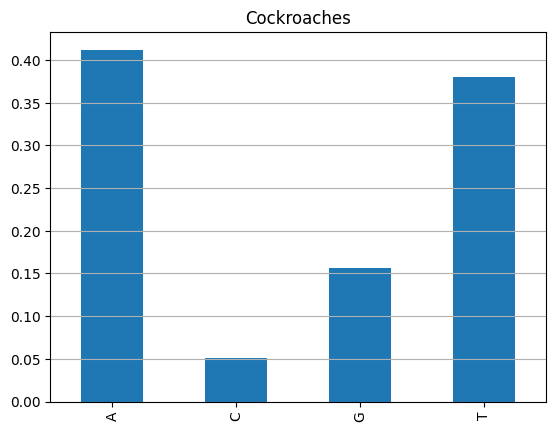

In [15]:
M = nuc_spectrum_to_matrix(cocks_mean_ms) # may use either rates or mutspect 
eq_prob = get_equilibrium_probabilities(M).astype(float)
print(eq_prob)
pd.Series(dict(zip(alphabet, eq_prob))).plot.bar()
# plt.yticks(np.linspace(0, 0.5, 21));
plt.grid(axis='y');
plt.title('Cockroaches');

[0.13163301 0.10532336 0.10522691 0.65781671]


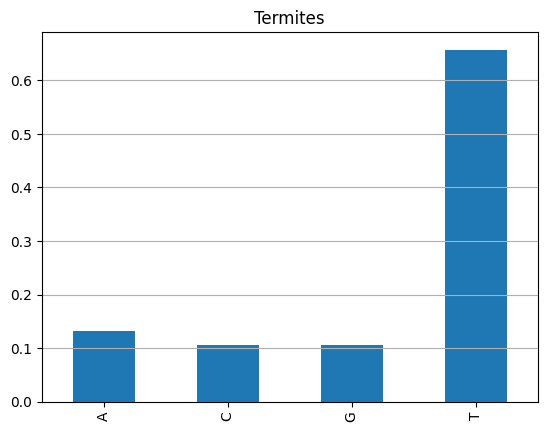

In [16]:
M = nuc_spectrum_to_matrix(terms_mean_ms) # may use either rates or mutspect 
eq_prob = get_equilibrium_probabilities(M).astype(float)
print(eq_prob)
pd.Series(dict(zip(alphabet, eq_prob))).plot.bar()
# plt.yticks(np.linspace(0, 0.5, 21));
plt.grid(axis='y');
plt.title('Termites');

In [24]:
cdn_sbs = cock_changes.groupby(['cdn1', 'cdn2'])['MutSpec'].sum()
M = cdn_spectrum_to_matrix(cdn_sbs)
eq_prob = get_equilibrium_probabilities(M).astype(float)

eq_freqs = pd.Series(dict(zip(possible_codons, eq_prob)))
eq_freqs.name = 'freq'
eq_freqs.index.name = 'cdn'
eq_freqs = eq_freqs.reset_index()
eq_freqs['aa'] = eq_freqs['cdn'].map(coda.translate_codon)
eq_freqs.sort_values('freq')

,cdn,freq,aa
21,CCC,0.000136,P
22,CCG,0.000415,P
37,GCC,0.000415,A
25,CGC,0.000415,R
53,TCC,0.001004,S
...,...,...,...
15,ATT,0.059387,I
48,TAA,0.064503,*
3,AAT,0.064503,N
12,ATA,0.064503,M


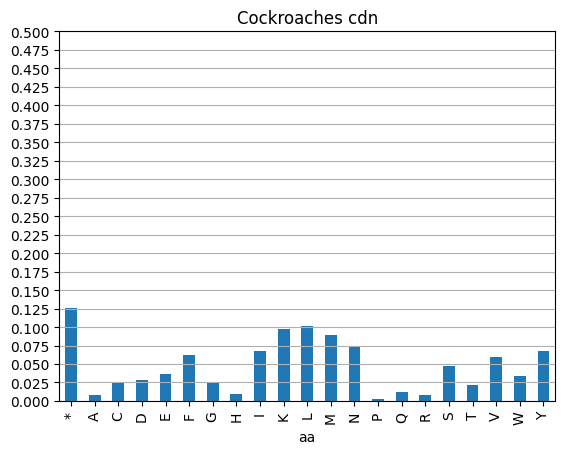

In [25]:
plt.yticks(np.linspace(0, 0.4, 17));
eq_freqs_aa_new = eq_freqs.groupby('aa').freq.sum()
eq_freqs_aa_new.plot.bar()
plt.yticks(np.linspace(0, 0.5, 21));
plt.grid(axis='y');
plt.title('Cockroaches cdn');

In [26]:
eq_freqs_aa_new

aa
*    0.125806
A    0.008064
C    0.025644
D    0.027853
E    0.036774
F    0.062086
G    0.024576
H    0.009139
I    0.067435
K    0.096702
L    0.101493
M    0.089032
N    0.073245
P    0.002646
Q    0.012066
R    0.008064
S    0.047376
T    0.021205
V    0.059501
W    0.033857
Y    0.067435
Name: freq, dtype: float64

In [27]:
cdn_sbs = term_changes.groupby(['cdn1', 'cdn2'])['MutSpec'].sum()
M = cdn_spectrum_to_matrix(cdn_sbs)
eq_prob = get_equilibrium_probabilities(M).astype(float)

eq_freqs = pd.Series(dict(zip(possible_codons, eq_prob)))
eq_freqs.name = 'freq'
eq_freqs.index.name = 'cdn'
eq_freqs = eq_freqs.reset_index()
eq_freqs['aa'] = eq_freqs['cdn'].map(coda.translate_codon)
eq_freqs.sort_values('freq')

/tmp/ipykernel_159226/3643108226.py:3: ComplexWarning: Casting complex values to real discards the imaginary part
  eq_prob = get_equilibrium_probabilities(M).astype(float)


,cdn,freq,aa
21,CCC,0.001165,P
37,GCC,0.001166,A
22,CCG,0.001166,P
25,CGC,0.001166,R
26,CGG,0.001167,R
...,...,...,...
32,GAA,0.045576,E
48,TAA,0.056961,*
12,ATA,0.056961,M
3,AAT,0.056961,N


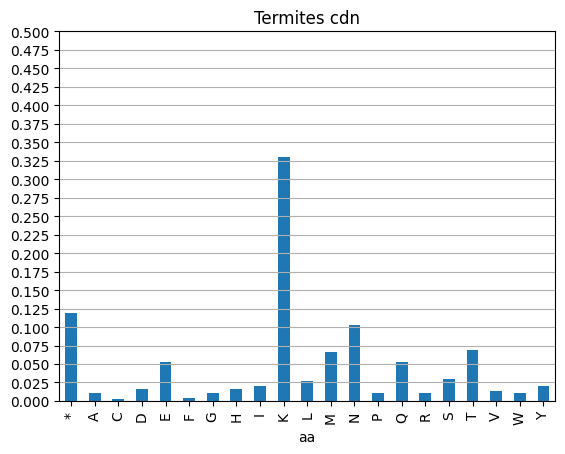

In [28]:
plt.yticks(np.linspace(0, 0.4, 17));
eq_freqs_aa_new = eq_freqs.groupby('aa').freq.sum()
eq_freqs_aa_new.plot.bar()
plt.yticks(np.linspace(0, 0.5, 21));
plt.grid(axis='y');
plt.title('Termites cdn');

In [29]:
eq_freqs_aa_new

aa
*    0.118954
A    0.011083
C    0.003284
D    0.016410
E    0.052873
F    0.004104
G    0.011093
H    0.016395
I    0.020510
K    0.330228
L    0.027074
M    0.066081
N    0.102495
P    0.011073
Q    0.052825
R    0.011083
S    0.030262
T    0.069220
V    0.013864
W    0.010580
Y    0.020510
Name: freq, dtype: float64